In [1]:
import re
import pandas as pd

# Path to the log file for expected
log_path = "my_program_output.log"
# path to the log file for particular
log_path2 = "my_program_output_particular.log"

In [2]:
def log_file_to_dfs(log_path, name):

    # Regular expression pattern to capture the relevant data
    pattern = (
        r"Running for W = (\d+) and K = (\d+).*?"
        r"Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?:(\d+):)?(\d+):(\d+(?:\.\d+)?).*?"
        r"Maximum resident set size \(kbytes\): (\d+)"
    )

    # Dictionaries to store the time and memory data (W, K) -> value
    time_data = {}
    memory_data = {}

    # Read the log file
    with open(log_path, "r") as file:
        log_data = file.read()

    # Find all matches and parse the values
    matches = re.finditer(pattern, log_data, re.DOTALL)
    for match in matches:
        w = int(match.group(1))
        k = int(match.group(2))
        hours = int(match.group(3) or 0)
        minutes = int(match.group(4))
        seconds = float(match.group(5))
        max_memory_kb = int(match.group(6))

        # Convert time to total seconds and memory to MB
        total_seconds = hours * 3600 + minutes * 60 + seconds
        max_memory_mb = max_memory_kb / 1024

        # Store the results in their respective dictionaries
        time_data[(w, k)] = total_seconds
        memory_data[(w, k)] = max_memory_mb

    # Extract unique W and K values for creating the DataFrames
    ws = sorted(set(w for w, k in time_data))
    ks = sorted(set(k for w, k in time_data))

    # Create 2D DataFrames for time and memory
    time_df = pd.DataFrame(index=ws, columns=ks)
    memory_df = pd.DataFrame(index=ws, columns=ks)

    # Populate the DataFrames with the extracted values
    for (w, k), time in time_data.items():
        time_df.loc[w, k] = time

    for (w, k), memory in memory_data.items():
        memory_df.loc[w, k] = memory

    # Add "W/K" in the corner by renaming the index and columns
    time_df.index.name = "W/K"
    memory_df.index.name = "W/K"

    # Save the DataFrames to CSV files
    time_df.to_csv(f"time_data_{name}.csv")
    memory_df.to_csv(f"memory_data_{name}.csv")

    # Display the DataFrames
    print("Time Data (s):")
    print(time_df)
    print("\nMemory Data (MB):")
    print(memory_df)

    return time_df, memory_df


time_df, memory_df = log_file_to_dfs(log_path, 'expected')
time_df2, memory_df2 = log_file_to_dfs(log_path2, 'particular')


Time Data (s):
       3     4      5      6       7       8       9       10       11  \
W/K                                                                      
3    0.09  0.09   0.11   0.15    0.32    0.46     0.8    1.79     3.19   
4    0.06  0.05   0.07   0.11     0.2    0.35    0.64    1.28     2.79   
5    0.11  0.06   0.07   0.12    0.17    0.33    0.65     1.6     2.62   
6    0.07  0.06   0.11   0.17    0.31    0.68    1.14    1.98     5.05   
7    0.07  0.08   0.14   0.24    0.68    1.17    2.53    4.72     8.33   
8    0.09  0.12   0.23   0.63    1.37    2.18    4.04    8.28     16.2   
9    0.11  0.25   0.58   0.84    1.75     4.7    9.06   15.85    34.13   
10   0.19   0.3   1.08   2.08    3.85    7.93   17.02   31.91    69.29   
11   0.18   0.5   1.38   3.51    7.05   15.52    29.8   62.67   123.07   
12   0.41  1.14   3.49   6.94   14.54   32.46    60.9  122.93   250.59   
13   0.94  1.65   4.96  13.09   29.05   61.88   118.9  245.68   505.02   
14   0.67   3.1  10.32 

In [3]:
# load the the data back
time_df = pd.read_csv("time_data_expected.csv", index_col=0)
memory_df = pd.read_csv("memory_data_expected.csv", index_col=0)
time_df2 = pd.read_csv("time_data_particular.csv", index_col=0)
memory_df2 = pd.read_csv("memory_data_particular.csv", index_col=0)

# make NANS into 0
time_df.fillna(0.1, inplace=True)
memory_df.fillna(20, inplace=True)
time_df2.fillna(20, inplace=True)
memory_df2.fillna(5000, inplace=True)

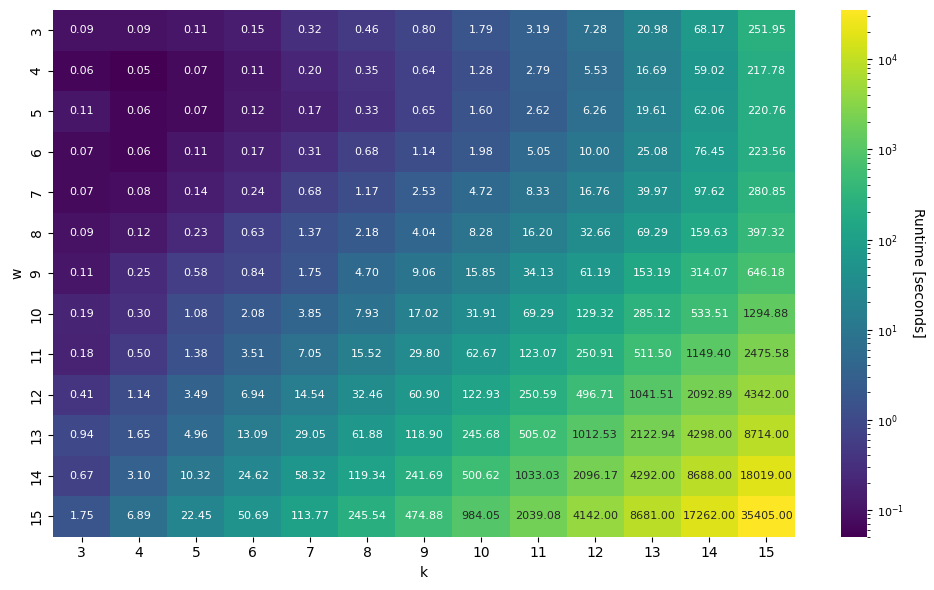

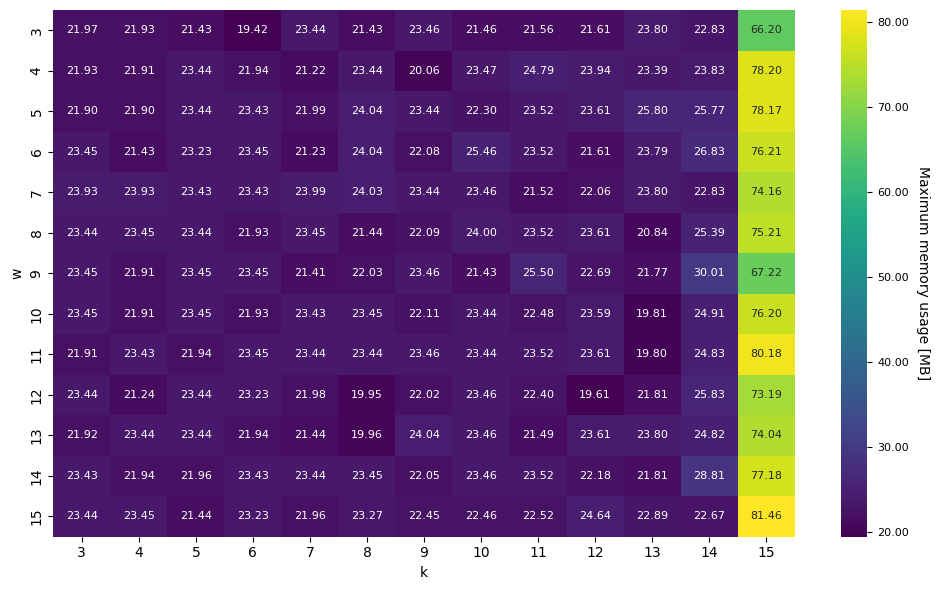

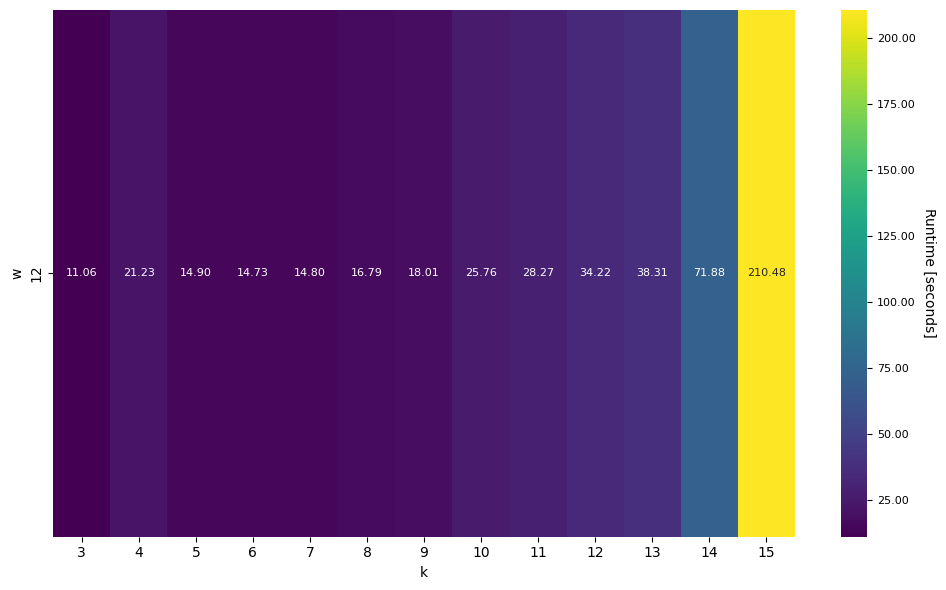

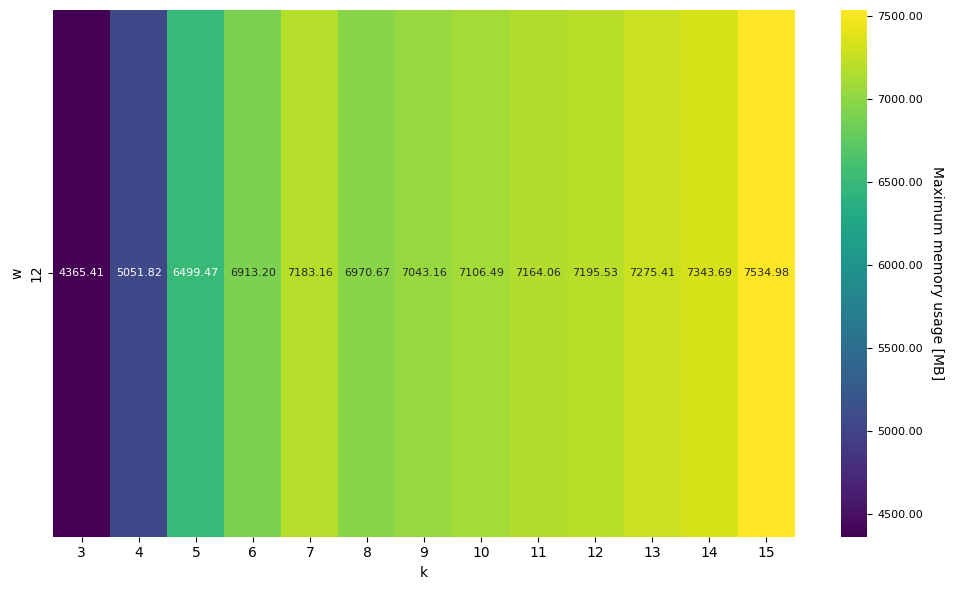

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm

# Function to format numbers normally with two decimal places
def format_normally(num):
    return f"{num:.2f}"

def plot_heatmap(dataframe, legend_name, log_scale=True):
    plt.figure(figsize=(10, 6))
    
    if log_scale:
        # Handle zeros and negative values by replacing them with a small positive number
        min_positive = dataframe[dataframe > 0].min().min()
        if pd.isnull(min_positive):
            min_positive = 1e-10  # Default small positive number if all values are zero or negative
        dataframe = dataframe.replace(0, min_positive / 10)
        dataframe = dataframe.clip(lower=min_positive / 10)
        
        # Create labels with normal formatting
        labels = dataframe.applymap(format_normally)
        
        # Get the min and max values for normalization
        vmin = dataframe.min().min()
        vmax = dataframe.max().max()
        
        # Create the heatmap with logarithmic normalization
        ax = sns.heatmap(
            dataframe,
            annot=labels,
            fmt="",
            cmap="viridis",
            norm=LogNorm(vmin=vmin, vmax=vmax),
            annot_kws={"size": 8}
        )
        
        # Customize the colorbar with logarithmic ticks
        cbar = ax.collections[0].colorbar
        exp_min = int(np.floor(np.log10(vmin)))
        exp_max = int(np.ceil(np.log10(vmax)))
        ticks = [10 ** exp for exp in range(exp_min + 1, exp_max)]
        cbar.set_ticks(ticks)
        
        # Formatter for the colorbar ticks in scientific notation
        def cbar_formatter(x, pos):
            if x == 0:
                return "0"
            exponent = int(np.log10(x))
            return r"$10^{{{}}}$".format(exponent)
        
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(cbar_formatter))
        cbar.ax.tick_params(labelsize=8)
    else:
        # For linear scale, ensure no negative values
        dataframe = dataframe.clip(lower=0)
        
        # Create labels with normal formatting
        labels = dataframe.applymap(format_normally)
        
        # Create the heatmap without normalization
        ax = sns.heatmap(
            dataframe,
            annot=labels,
            fmt="",
            cmap="viridis",
            annot_kws={"size": 8}
        )
        
        # Customize the colorbar with linear ticks
        cbar = ax.collections[0].colorbar
        
        # Formatter for the colorbar ticks in normal decimal format
        def cbar_formatter(x, pos):
            return f"{x:.2f}"
        
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(cbar_formatter))
        cbar.ax.tick_params(labelsize=8)
    
    # Add label to the colorbar
    cbar.set_label(legend_name, rotation=270, labelpad=15)
    
    plt.xlabel("k")
    plt.ylabel("w")
    plt.tight_layout()

    plt.savefig(f"{legend_name}.png", dpi=500)

    plt.show()


# Example usage with your dataframes
plot_heatmap(time_df, "Runtime [seconds]", log_scale=True)  # Exponential scale
plot_heatmap(memory_df, "Maximum memory usage [MB]", log_scale=False)  # Linear scale
plot_heatmap(time_df2, "Runtime [seconds]", log_scale=False)  # Exponential scale
plot_heatmap(memory_df2, "Maximum memory usage [MB]", log_scale=False)  # Linear scale
